In [51]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
%pip install pandas
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
from sklearn.ensemble import IsolationForest
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
#sample_submission = pd.read_csv(dirname+"/"+filenames[0])
train_dataset = pd.read_csv('/Users/ayberk/Downloads/train.csv')
test_dataset = pd.read_csv('/Users/ayberk/Downloads/test.csv')
plot_dataset = train_dataset.copy()
train_dataset.set_index('DATETIME',inplace = True)
train_dataset.fillna(method= 'ffill',inplace = True)


#remove first 6 char of the string
train_dataset['SERVER'] = train_dataset['SERVER'].str[6:]
train_dataset['CPU'] = train_dataset['CPU'].str[4:]

train_dataset = train_dataset.loc['2020-05-15 00:00:00':'2020-05-30 00:00:00']






[notice] A new release of pip available: 22.2.2 -> 23.1.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [52]:
def run_isolation_forest(model_data: pd.DataFrame, contamination=0.005, n_estimators=200, max_samples=0.7) -> pd.DataFrame:
    
    IF = (IsolationForest(random_state=0,
                          contamination=contamination,
                          n_estimators=n_estimators,
                          max_samples=max_samples)
         )
    
    IF.fit(model_data)
    
    output = pd.Series(IF.predict(model_data)).apply(lambda x: 1 if x == -1 else 0)
    
    score = IF.decision_function(model_data)
    
    return output, score

In [53]:
outliers, score = run_isolation_forest(train_dataset)



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [54]:
outliers = np.nan_to_num(outliers, nan=0)

# Assign outliers and score to the train_dataset
train_dataset = train_dataset.assign(Outliers=outliers, Score=score)
train_dataset

,SERVER,CPU,CPULOAD,Outliers,Score
DATETIME,,,,,
2020-05-15 00:00:00+03:00,301,0,5.56,0,0.109253
2020-05-15 00:00:00+03:00,301,1,15.31,0,0.132245
2020-05-15 00:00:00+03:00,301,10,4.17,0,0.154663
2020-05-15 00:00:00+03:00,301,11,14.38,0,0.144331
2020-05-15 00:00:00+03:00,301,12,0.84,0,0.151034
...,...,...,...,...,...
2020-05-29 23:45:00+03:00,305,5,17.45,0,0.132915
2020-05-29 23:45:00+03:00,305,6,15.13,0,0.136962
2020-05-29 23:45:00+03:00,305,7,18.26,0,0.145937


In [55]:
def outliers(thresh):
    print(f'Number of Outliers below Anomaly Score Threshold {thresh}:')
    print(len(train_dataset.query(f"Outliers == 1 & Score <= {thresh}")))

In [56]:
train_dataset.head()

,SERVER,CPU,CPULOAD,Outliers,Score
DATETIME,,,,,
2020-05-15 00:00:00+03:00,301,0,5.56,0,0.109253
2020-05-15 00:00:00+03:00,301,1,15.31,0,0.132245
2020-05-15 00:00:00+03:00,301,10,4.17,0,0.154663
2020-05-15 00:00:00+03:00,301,11,14.38,0,0.144331
2020-05-15 00:00:00+03:00,301,12,0.84,0,0.151034


In [57]:
# Print outliers and scores
count = 0
for i in range(len(train_dataset)):
    if train_dataset.iloc[i]['Outliers'] == 1 and train_dataset.iloc[i]['Score'] <= -0.05:
        count +=1
print(count)

#Get anomalies_df
anomalies_df = train_dataset.query("Outliers == 1 & Score <= -0.05")
anomalies_df

79


,SERVER,CPU,CPULOAD,Outliers,Score
DATETIME,,,,,
2020-05-15 04:30:00+03:00,301,15,21.89,1,-0.064465
2020-05-15 19:00:00+03:00,301,4,48.37,1,-0.101451
2020-05-17 04:30:00+03:00,305,0,3.27,1,-0.059580
2020-05-19 03:00:00+03:00,301,16,19.62,1,-0.064183
2020-05-20 13:00:00+03:00,301,0,45.41,1,-0.083468
...,...,...,...,...,...
2020-05-28 13:45:00+03:00,301,10,46.06,1,-0.081260
2020-05-28 20:00:00+03:00,301,0,55.07,1,-0.146222
2020-05-29 10:30:00+03:00,301,10,48.60,1,-0.100337


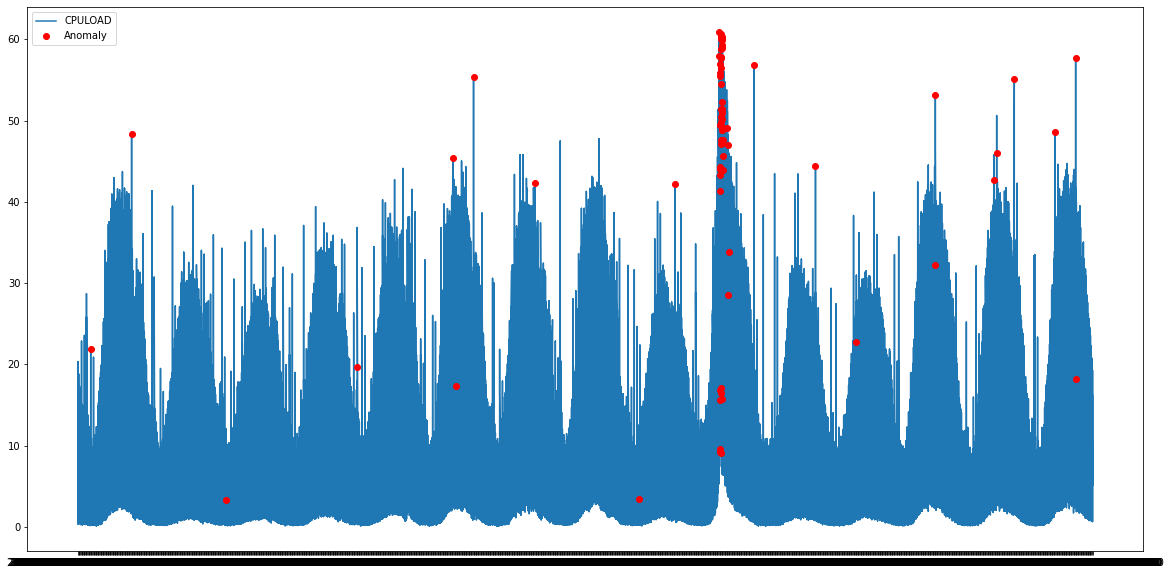

In [58]:
#draw a plot of train_dataset and anomalies_df
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(train_dataset['CPULOAD'], label='CPULOAD')
plt.plot(anomalies_df['CPULOAD'], 'ro', label='Anomaly')
plt.legend(loc='upper left')
plt.show()



In [59]:
servers = plot_dataset.groupby(plot_dataset['SERVER'] == "CIHAZ_301")

first_server = servers.get_group(True)
second_server = servers.get_group(False)

first_server = first_server.pivot(index = 'DATETIME',columns='CPU', values='CPULOAD')


second_server = second_server.pivot(index = 'DATETIME',columns = 'CPU', values = 'CPULOAD')


In [70]:
anomalies = anomalies_df.groupby(anomalies_df['SERVER'] == "301")
first_anomalies = anomalies.get_group(True)
second_anomalies = anomalies.get_group(False)


In [71]:
first_anomalies

,SERVER,CPU,CPULOAD,Outliers,Score
DATETIME,,,,,
2020-05-15 04:30:00+03:00,301,15,21.89,1,-0.064465
2020-05-15 19:00:00+03:00,301,4,48.37,1,-0.101451
2020-05-19 03:00:00+03:00,301,16,19.62,1,-0.064183
2020-05-20 13:00:00+03:00,301,0,45.41,1,-0.083468
2020-05-20 14:00:00+03:00,301,22,17.31,1,-0.110422
2020-05-20 20:15:00+03:00,301,13,55.43,1,-0.167249
2020-05-21 18:00:00+03:00,301,11,42.28,1,-0.061572
2020-05-23 19:45:00+03:00,301,0,42.18,1,-0.059194
2020-05-24 11:30:00+03:00,301,21,15.55,1,-0.059109


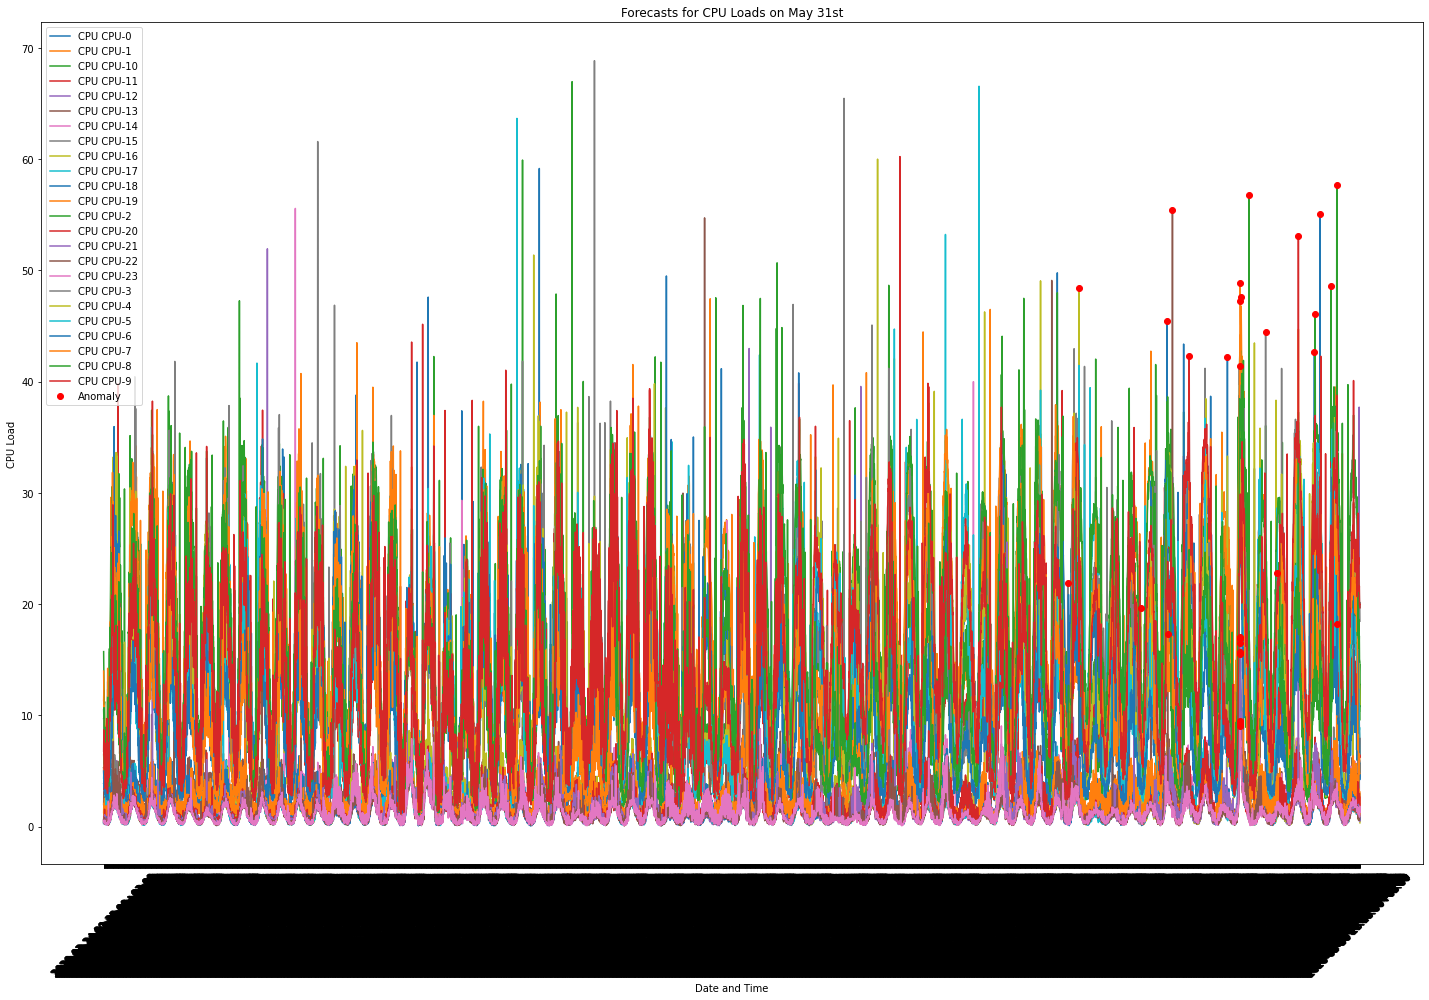

In [72]:
plt.figure(figsize=(20,14))
for cpu_id in first_server.columns:
    cpu_data = first_server[cpu_id]
    plt.plot(cpu_data.index, cpu_data.values, label=f'CPU {cpu_id}')
# Plot anomalies in server = 301
plt.plot(first_anomalies.index, first_anomalies['CPULOAD'], 'ro', label='Anomaly')

plt.xlabel('Date and Time')
plt.ylabel('CPU Load')
plt.title('Forecasts for CPU Loads on May 31st')
plt.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



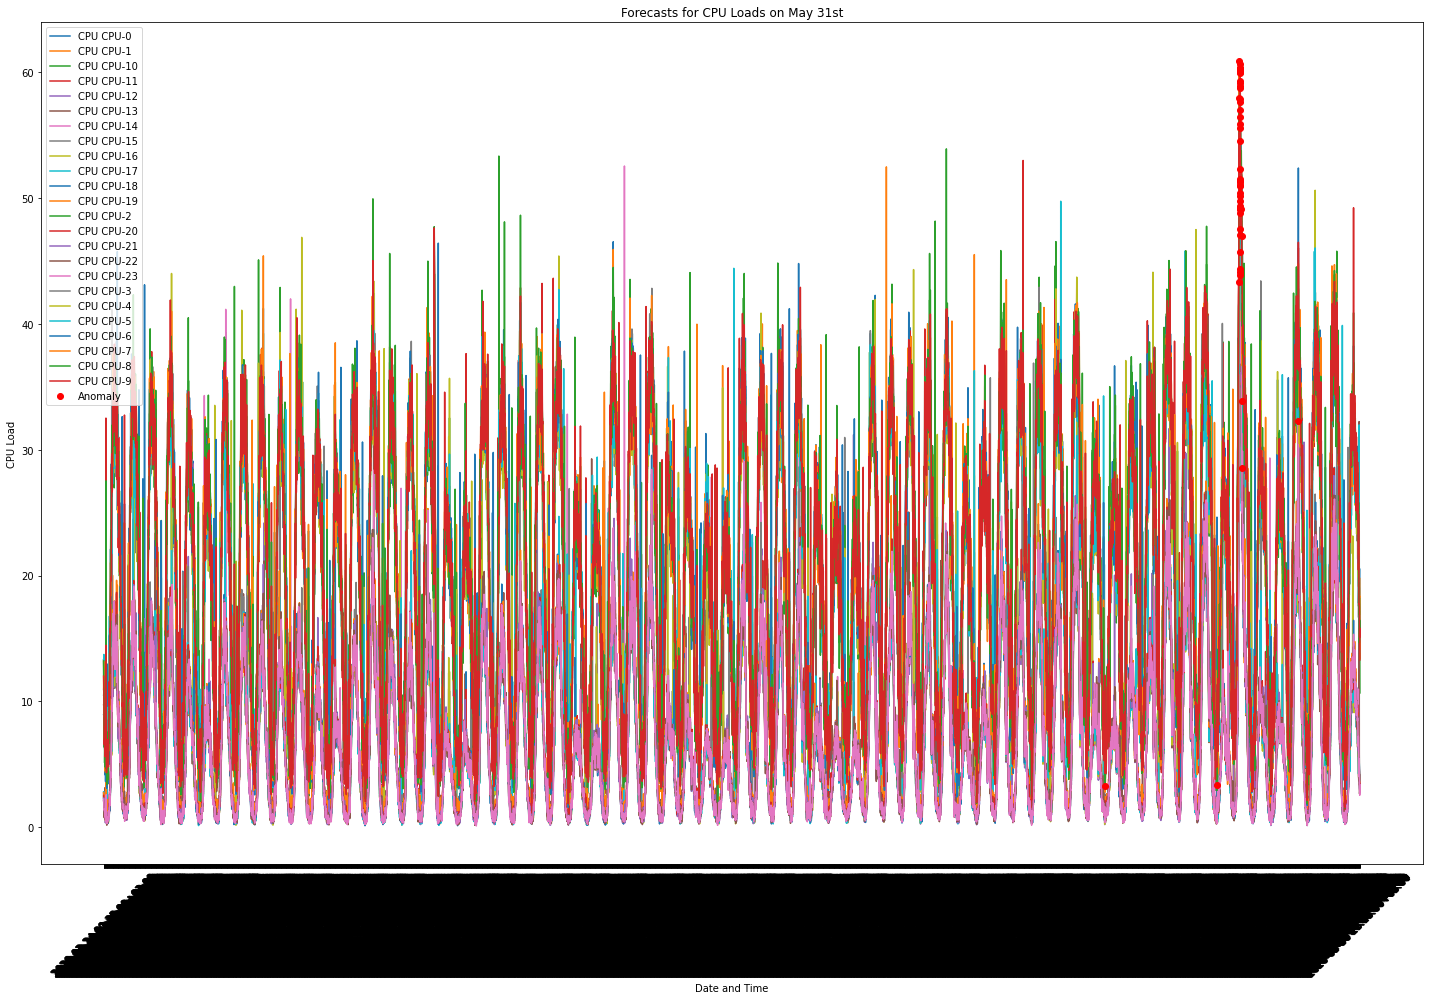

In [73]:
plt.figure(figsize=(20,14))
for cpu_id in second_server.columns:
    cpu_data = second_server[cpu_id]
    plt.plot(cpu_data.index, cpu_data.values, label=f'CPU {cpu_id}')
# Plot anomalies in server = 301
plt.plot(second_anomalies.index, second_anomalies['CPULOAD'], 'ro', label='Anomaly')

plt.xlabel('Date and Time')
plt.ylabel('CPU Load')
plt.title('Forecasts for CPU Loads on May 31st')
plt.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

